Universidad Torcuato Di Tella

Licenciatura en Tecnología Digital\
**Tecnología Digital VI: Inteligencia Artificial**


In [19]:
!pip install torchaudio
!pip install  pydub
!pip install soundfile
!pip install wandb
import os
import torch
import torchaudio
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchaudio.datasets import GTZAN
from torch.utils.data import DataLoader
import torchaudio.transforms as tt
from torch.utils.data import random_split
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import soundfile as sf
import wandb


# TP3: Encodeador de música



## Orden de pasos

0. Elijan GPU para que corra mas rapido (RAM --> change runtime type --> T4 GPU)
1. Descargamos el dataset y lo descomprimimos en alguna carpeta en nuestro drive.
2. Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos.
3. Visualización de los archivos
4. Clasificación
5. Evaluación




In [20]:
wandb.login(key = "3d2152b235c7d6ade2434ebc12dd4b386e1af8f1")
project_name='Music_genre_classification'

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/estanislaorioszgaib/.netrc


### 2. Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos.

En nuestro caso no hace falta ya que estamos trabajando en Visual Studio Code y no en Google Colab

In [21]:
#from google.colab import drive
#drive.mount('/content/drive')

data_dir es el path donde pusimos la carpeta genres. "'//content/drive/MyDrive/Materias/TD6 - Inteligencia Artificial/TPs/2023/TP4/genres/'" es un ejemplo. Modificar.

In [22]:
import os
data_dir='../genres_5sec'
list_files=os.listdir(data_dir)
classes=[]
for file in list_files:
  name='{}/{}'.format(data_dir,file)
  if os.path.isdir(name):
    classes.append(file)
classes

['pop',
 'metal',
 'disco',
 'blues',
 'reggae',
 'classical',
 'rock',
 'hiphop',
 'country',
 'jazz']

In [23]:
samplerate=22050
def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts #' '.join(parts[0])

class MusicDataset(Dataset):
    def __init__(self, root):
        super().__init__()
        self.root = root
        self.files =[]
        for c in classes:
          self.files = self.files + [fname for fname in os.listdir(os.path.join(root,c)) if fname.endswith('.wav')]
        self.classes = list(set(parse_genres(fname) for fname in self.files))
        #self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        genre = parse_genres(fname)
        fpath = os.path.join(self.root, genre, fname)
        class_idx = self.classes.index(genre)
        
        try:
            # Intenta cargar el archivo usando torchaudio
            audio, sr = torchaudio.load(fpath)
        except RuntimeError:
            # Si torchaudio falla, usa soundfile para cargar el archivo
            audio, sr = sf.read(fpath)
            audio = torch.tensor(audio).unsqueeze(0)  # Asegura que el audio tenga el tamaño adecuado
        
        return audio, class_idx
dataset = MusicDataset(data_dir)

### 3. Visualización de los archivos

In [24]:
waveform,label = dataset[0]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))

shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 5 


shape of spectogram torch.Size([1, 201, 552])


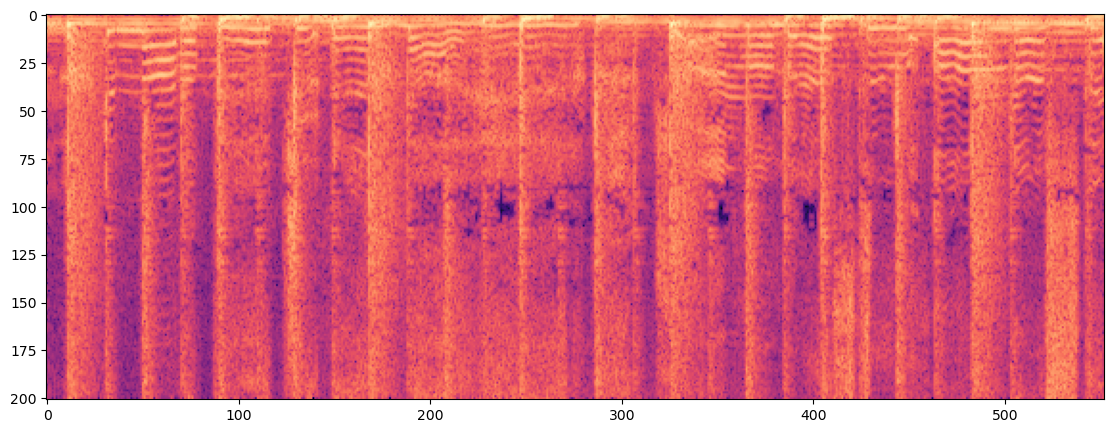

In [25]:
specgram=tt.Spectrogram()(waveform)
print("shape of spectogram {}".format(specgram.size()))

plt.figure(figsize=(20, 5))
plt.imshow(specgram.log2()[0,:,:].numpy(),cmap='magma')


Waveform: tensor([[ 0.0345,  0.0482,  0.0643,  ..., -0.1070, -0.0598, -0.0341]])



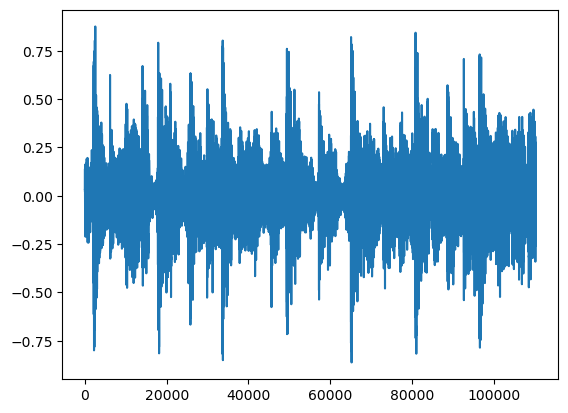

In [26]:
print("Waveform: {}\n".format(waveform))

plt.figure()
plt.plot(waveform.t().numpy())

Escuchamos el espectograma con la librería de audio

In [27]:
import IPython
IPython.display.Audio(waveform,rate=samplerate)

In [28]:
specgram.size()

torch.Size([1, 201, 552])

In [29]:
random_seed = 42
torch.manual_seed(random_seed);
val_size = 100
test_size = 100
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds),len(val_ds),len(test_ds)

(790, 100, 100)

In [30]:
from torch.utils.data import DataLoader
batch_size = 20

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds,1, num_workers=4, pin_memory=True)

### 4. Clasificación

In [31]:
class MLP(nn.Module):
    def __init__(self, n_input, hidden_dim=64, n_output=10):
        super(MLP, self).__init__()
        # Define layers dynamically
        self.fc1 = nn.Linear(n_input, hidden_dim)  # First hidden layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # Second hidden layer
        self.fc3 = nn.Linear(hidden_dim, n_output)  # Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))  # First hidden layer with ReLU
        #x = F.relu(self.fc2(x))  # Second hidden layer with ReLU
        #x = self.fc3(x)          # Output layer, no activation as it's used for logits
        return F.log_softmax(x, dim=1)

In [32]:
device = torch.device('cuda:0' if torch.cuda.is_available() else
                      'mps' if torch.backends.mps.is_available() else
                      'cpu')

In [33]:
model = MLP(n_input=110250, n_output=len(classes))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

MLP(
  (fc1): Linear(in_features=110250, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)
Number of parameters: 7060874


In [34]:
len(classes)

10

In [35]:
import gc
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Configuración de modelo, DataLoaders, y dispositivo (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YourModel().to(device)  # Reemplaza `YourModel` con el nombre de tu clase de modelo
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
valid_dl = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=0)

# Función de entrenamiento y validación
def train_and_validate(model, train_dl, valid_dl, device, num_epochs=5, lr=0.0005):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    valid_losses = []

    for epoch in range(num_epochs):
        model.train()
        losses = []

        # Entrenamiento
        for wav, genre_index in train_dl:
            optimizer.zero_grad()
            wav = wav.to(device)
            genre_index = torch.as_tensor(genre_index).to(device)

            # Forward
            out = model(wav)
            loss = F.nll_loss(out.squeeze(), genre_index)

            # Backward
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

            # Liberar memoria
            del wav, genre_index, loss, out
            torch.cuda.empty_cache()
            gc.collect()

        print(f'Epoch: [{epoch+1}/{num_epochs}], Train loss: {np.mean(losses):.4f}')

        # Validación
        model.eval()
        y_true = []
        y_pred = []
        losses = []
        correct = 0

        with torch.no_grad():
            for wav, genre_index in valid_dl:
                wav = wav.to(device)
                genre_index = genre_index.to(device)

                out = model(wav)
                loss = F.nll_loss(out.squeeze(), genre_index)
                losses.append(loss.item())

                pred = out.argmax(dim=-1).flatten()
                correct += pred.eq(genre_index).sum().item()
                y_true.extend(genre_index.cpu().numpy())
                y_pred.extend(pred.cpu().numpy())

                # Liberar memoria
                del wav, genre_index, loss, out
                torch.cuda.empty_cache()
                gc.collect()

        accuracy = correct / len(valid_dl.dataset)
        valid_loss = np.mean(losses)
        print(f'Epoch: [{epoch+1}/{num_epochs}], Valid loss: {valid_loss:.4f}, Valid accuracy: {accuracy:.4f}')

        valid_losses.append(valid_loss)
        if np.argmin(valid_losses) == epoch:
            print(f'Saving the best model at {epoch+1} epochs!')
            torch.save(model.state_dict(), 'best_model.ckpt')

# Ejecutar entrenamiento y validación
train_and_validate(model, train_dl, valid_dl, device)


NameError: name 'YourModel' is not defined

In [20]:
import gc
from sklearn.metrics import accuracy_score, confusion_matrix
import torch.nn.functional as F

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
valid_losses = []
num_epochs = 5
torch.cuda.empty_cache()
gc.collect() #importante para ir liberando memoria ram
for epoch in range(num_epochs):
    losses = []

    # Train
    model.train()
    for wav, genre_index in train_dl:
        optimizer.zero_grad()  # Clear gradients
        wav=wav.to(device)
        genre_index =torch.as_tensor(genre_index).to(device)

        # Forward
        out = model(wav)
        #M5
        loss = F.nll_loss(out.squeeze(), genre_index)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        del wav #importante para ir liberando memoria ram
        del genre_index #importante para ir liberando memoria ram
        del loss #importante para ir liberando memoria ram
        del out  #importante para ir liberando memoria ram
        torch.cuda.empty_cache()  #importante para ir liberando memoria ram
        gc.collect() #importante para ir liberando memoria ram

    print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, num_epochs, np.mean(losses)))

    # Validation
    model.eval()
    y_true = []
    y_pred = []
    losses = []
    correct =0
    for wav, genre_index in valid_dl:
        #print(wav, genre, index)
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        out = model(wav)

        loss = F.nll_loss(out.squeeze() , genre_index)
    
        losses.append(loss.item())
        #M5
        pred= out.argmax(dim=-1).flatten()
        # append labels and predictions
        correct += pred.eq(genre_index).sum().item()
        y_true.extend(genre_index)
        y_pred.extend(pred)
        del wav #importante para ir liberando memoria ram
        del genre_index #importante para ir liberando memoria ram
        del loss #importante para ir liberando memoria ram
        del out  #importante para ir liberando memoria ram
        torch.cuda.empty_cache()  #importante para ir liberando memoria ram
        gc.collect() #importante para ir liberando memoria ram

    accuracy =correct/ len(valid_dl.dataset)
    valid_loss = np.mean(losses)
    print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, valid_loss, accuracy))

    # Save model
    valid_losses.append(valid_loss.item())
    if np.argmin(valid_losses) == epoch:
        print('Saving the best model at %d epochs!' % epoch)
        torch.save(model.state_dict(), 'best_model.ckpt')

Traceback (most recent call last):
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/TD6/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
  File "/opt/anaconda3/envs/TD6/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
        exitcode = _main(fd, parent_sentinel)exitcode = _main(fd, parent_sentinel)

                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/opt/anaconda3/envs/TD6/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
  File "/opt/anaconda3/envs/TD6/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
    self = reduction.pickle.load(from_parent)
             ^ ^ ^ ^ ^ ^ ^ ^ ^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^AttributeError^^: ^Can't get attribute 'MusicDataset' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>^


RuntimeError: DataLoader worker (pid(s) 39034, 39035, 39036, 39037) exited unexpectedly



### 5. Evaluación



In [ ]:
test_dl = DataLoader(test_ds,1,shuffle=True, num_workers=4, pin_memory=True)

In [ ]:
# Load the best model
S = torch.load('best_model.ckpt')
model.load_state_dict(S)
print('loaded!')

# Run evaluation
model.eval()
y_true = []
y_pred = []
correct = 0
with torch.no_grad():
    for wav, genre_index in test_dl:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        out = model(wav)

        pred= out.argmax(dim=-1).flatten()
        # append labels and predictions
        correct += pred.eq(genre_index).sum().item()
        y_true.extend(genre_index)
        y_pred.extend(pred)

accuracy =correct/ len(test_dl.dataset)
print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, valid_loss, accuracy))


In [ ]:
waveform,label= test_dl.dataset[12]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))

In [ ]:
import IPython
IPython.display.Audio(waveform, rate=22050)

In [ ]:
wav= torch.unsqueeze(waveform, dim=0)
model.to(device)
wav =wav.to(device)
out = model(wav)
pred= out.argmax(dim=-1).flatten()
classes[pred], classes[label]